In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from scipy import stats
import seaborn as sns
%matplotlib inline

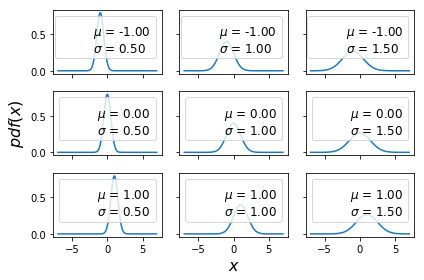

In [12]:
mu_params = [-1, 0, 1]
sd_params = [0.5, 1, 1.5]
x = np.linspace(-7, 7, 100)
f, ax = plt.subplots(len(mu_params), len(sd_params), sharex=True,
 sharey=True)
for i in range(3):
   for j in range(3):
       mu = mu_params[i]
       sd = sd_params[j]
       y = stats.norm(mu, sd).pdf(x)
       ax[i,j].plot(x, y)
       ax[i,j].plot(0, 0,
       label="$\\mu$ = {:3.2f}\n$\\sigma$ = {:3.2f}".format
         (mu, sd), alpha=0)
       ax[i,j].legend(fontsize=12)
ax[2,1].set_xlabel('$x$', fontsize=16)
ax[1,0].set_ylabel('$pdf(x)$', fontsize=16)
plt.tight_layout()

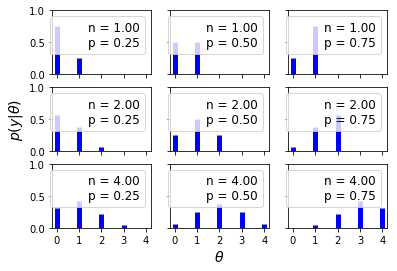

In [13]:
n_params = [1, 2, 4]
p_params = [0.25, 0.5, 0.75]
 
x = np.arange(0, max(n_params)+1)
f, ax = plt.subplots(len(n_params), len(p_params), sharex=True,
  sharey=True)
for i in range(3):
    for j in range(3):
        n = n_params[i]
        p = p_params[j]
        y = stats.binom(n=n, p=p).pmf(x)
        ax[i,j].vlines(x, 0, y, colors='b', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="n = {:3.2f}\np = {:3.2f}".format(n, p), alpha=0)
        ax[i,j].legend(fontsize=12)
ax[2,1].set_xlabel('$\\theta$', fontsize=14)
ax[1,0].set_ylabel('$p(y|\\theta)$', fontsize=14)
ax[0,0].set_xticks(x)

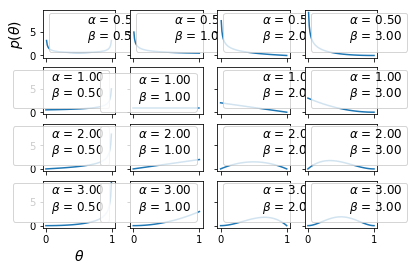

In [14]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True,
 sharey=True)
for i in range(4):
   for j in range(4):
       a = params[i]
       b = params[j]
       y = stats.beta(a, b).pdf(x)
       ax[i,j].plot(x, y)
       ax[i,j].plot(0, 0, label="$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(a, b), alpha=0)
       ax[i,j].legend(fontsize=12)
ax[3,0].set_xlabel('$\\theta$', fontsize=14)
ax[0,0].set_ylabel('$p(\\theta)$', fontsize=14)

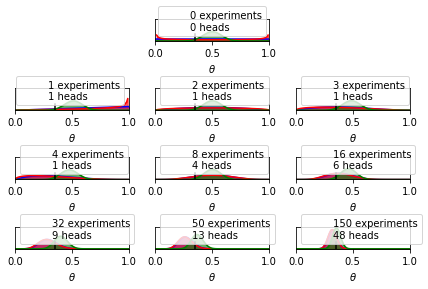

In [15]:
theta_real = 0.35
trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
beta_params = [(1, 1), (0.5, 0.5), (20, 20)]
dist = stats.beta
x = np.linspace(0, 1, 100)
for idx, N in enumerate(trials):
    if idx == 0:
        plt.subplot(4,3, 2)
    else:
        plt.subplot(4,3, idx+3)
    y = data[idx]
    for (a_prior, b_prior), c in zip(beta_params, ('b', 'r', 'g')):
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.plot(x, p_theta_given_y, c)
        plt.fill_between(x, 0, p_theta_given_y, color=c, alpha=0.6)
    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label="{:d} experiments\n{:d} heads".format(N,
     y), alpha=0)
    plt.xlim(0,1)
    plt.ylim(0,12)
    plt.xlabel(r'$\theta$')
    plt.legend()
    plt.gca().axes.get_yaxis().set_visible(False)
plt.tight_layout()

In [16]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
print(data)

[1 0 0 0]


Optimization terminated successfully.
         Current function value: 3.819085
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


100%|██████████| 1500/1500 [00:00<00:00, 7295.41it/s]


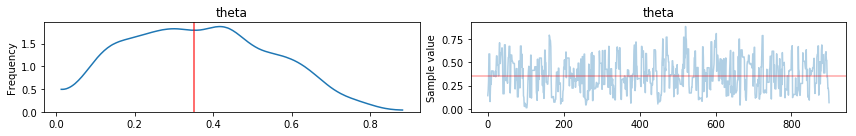

In [19]:
 with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)
    
    burnin = 100
    chain = trace[burnin:]
    pm.traceplot(chain, lines={'theta':theta_real});

100%|██████████| 1500/1500 [00:00<00:00, 5081.51it/s]


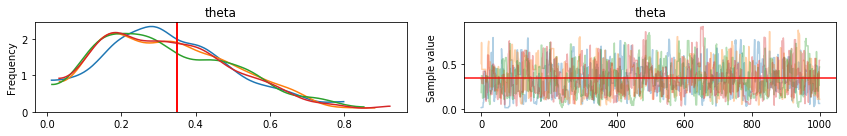

In [20]:
with our_first_model:
   step = pm.Metropolis()
   multi_trace = pm.sample(1000, step=step, njobs=4)
   burnin = 0
   multi_chain = multi_trace[burnin:]
   pm.traceplot(multi_chain, lines={'theta':theta_real});

In [21]:
pm.gelman_rubin(multi_chain)

{'theta': 0.999956784775479, 'theta_logodds__': 1.0006170008924888}

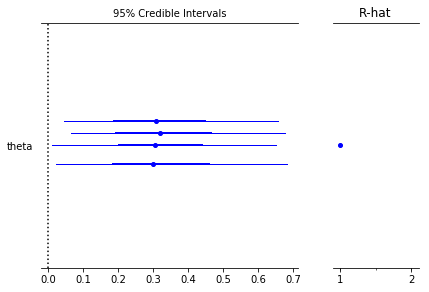

In [22]:
pm.forestplot(multi_chain, varnames=['theta']);

In [23]:
pm.summary(multi_chain)


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.334            0.177            0.006            [0.043, 0.677]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.060          0.194          0.308          0.451          0.718



In [24]:
pm.df_summary(multi_chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
theta,0.333587,0.176675,0.006343,0.043382,0.676765


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1196bf630>]], dtype=object)

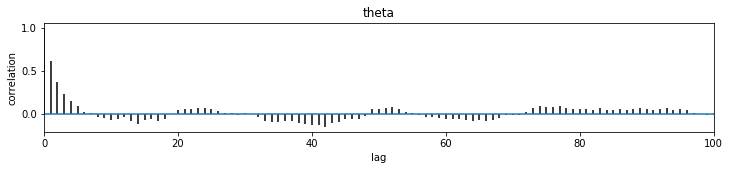

In [25]:
pm.autocorrplot(chain)

In [26]:
pm.effective_n(multi_chain)['theta']

708.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119824f60>], dtype=object)

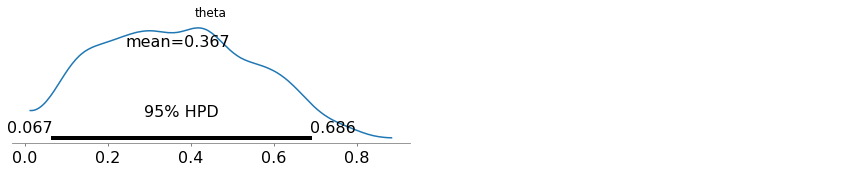

In [27]:
pm.plot_posterior(chain, kde_plot=True)

In [ ]:
pm.plot_posterior(chain, kde_plot=True, rope=[0.45, .55])

In [ ]:
pm.plot_posterior(chain, kde_plot=True, ref_val=0.5)

In [ ]:
N_samples =  [30, 30, 30]
G_samples =  [18, 18, 18]
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
   data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-
     G_samples[i]]))

In [ ]:
with pm.Model() as model_h:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    theta = pm.Beta('theta', alpha, beta, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)
trace_j = pm.sample(2000)
chain_h = trace_h[200:]
pm.traceplot(chain_h)